In [1]:
#============================================================================================
# Classifier Training
# Author: Gerald M (Changed by Maksim L)
#
# This script uses a convolution neural network classifier, to train for cells and non-cell
# objects.
#============================================================================================

import os
import random
import shutil
import datetime
from multiprocessing import cpu_count
import skimage.exposure

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Reshape, RepeatVector
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop
import tensorflow as tf

os.environ['MKL_NUM_THREADS'] = str(cpu_count())
os.environ['GOTO_NUM_THREADS'] = str(cpu_count())
os.environ['OMP_NUM_THREADS'] = str(cpu_count())
os.environ['openmp'] = 'True'

config = tf.ConfigProto(device_count={"GPU" : 1, "CPU" : cpu_count()})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

def AHE(img):
    img_adapteq = skimage.exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

#=============================================================================================
# Precheck on directory structure
#=============================================================================================

if os.listdir('8-bit_lowfat/test_data/cell/'):
    print 'Warning! Files detected in test data directory!'
    print 'Moving files back to training data directory...'

    for f in os.listdir('8-bit_lowfat/test_data/cell/'):
        shutil.move('8-bit_lowfat/test_data/cell/'+f,'8-bit_lowfat/training_data/cell/'+f)

    for f in os.listdir('8-bit_lowfat/test_data/nocell/'):
        shutil.move('8-bit_lowfat/test_data/nocell/'+f,'8-bit_lowfat/training_data/nocell/'+f)
        
    print 'Done!\n'

/opt/anaconda/envs/deeplearn/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

#=============================================================================================
# Construction of Convolution Neural Network
#=============================================================================================

print "Constructing Convolution Neural Network..."

# Create object of sequential class
classifier = Sequential()

# Convolution operation
# Number of filters
# Shape of each filter
# Input shape in first two, input type in third, 3 = RGB
# activation function, relu = rectifier function
classifier.add(Conv2D(8, (3, 3), input_shape = (80, 80, 1), activation = 'relu'))

# Pooling operation
# Pooling reduces size of images in order to reduce number of nodes
# 2x2 matrix
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Batch normalization
# Normalize the activations of the previous layer at each batch
# i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
classifier.add(BatchNormalization())

classifier.add(Conv2D(16, (3, 3), input_shape = (80, 80, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(BatchNormalization())

classifier.add(Conv2D(32, (3, 3), input_shape = (80, 80, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(BatchNormalization())

classifier.add(Conv2D(32, (3, 3), input_shape = (80, 80, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(BatchNormalization())

# Prevent nodes from generating same classifiers
classifier.add(Dropout(0.5))

# Flattening operation
# Convert pooled images into vectors

classifier.add(Flatten())

# Connect the set of nodes which input to connected layers
# Units is number of nodes
classifier.add(Dense(units = 128, activation = 'relu'))

# Prevent nodes from generating same classifiers
classifier.add(Dropout(0.5))

# Initialise output layer
classifier.add(Dense(2, activation='softmax')) #softmax/sigmoid , activation = 'sigmoid'

# Compile
# Optimizer is stochastic gradient descent
# Loss is loss function
# Metric is performance metric
optimizer = RMSprop(lr=1e-4)
classifier.compile(optimizer = optimizer, loss='binary_crossentropy', metrics = ['accuracy'])

classifier.summary()

print "Done!\n"

Constructing Convolution Neural Network...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 8)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 39, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (Non

In [3]:
#=============================================================================================
# Preparing training and test data
#=============================================================================================

from keras.preprocessing.image import ImageDataGenerator

print "Splitting all training data into 70% training and 30% test data directories..."

cell_data = os.listdir('8-bit_lowfat/training_data/cell/')
nocell_data = os.listdir('8-bit_lowfat/training_data/nocell/')

validation_cell_data = random.sample(cell_data, int(0.3*len(cell_data)))
validation_nocell_data = random.sample(nocell_data, int(0.3*len(nocell_data)))

for f in validation_cell_data:
    shutil.move('8-bit_lowfat/training_data/cell/'+f,'8-bit_lowfat/test_data/cell/'+f)

for f in validation_nocell_data:
    shutil.move('8-bit_lowfat/training_data/nocell/'+f,'8-bit_lowfat/test_data/nocell/'+f)

# training data
#train_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=p.keras_preprocess_func())
#training_data = train_datagen.flow_from_directory('8-bit_lowfat/training_data', target_size = (80, 80), batch_size = 32, class_mode = 'binary', color_mode = 'grayscale')
#training_data = train_datagen.flow_from_directory('8-bit_lowfat/training_data', target_size = (80, 80), batch_size = 32, class_mode = 'binary', color_mode = 'grayscale', save_to_dir='preview', save_prefix='cell', save_format='jpeg')
# validation data
test_datagen = ImageDataGenerator(rescale = 1./255)
test_data = test_datagen.flow_from_directory('8-bit_lowfat/test_data', target_size = (80, 80), batch_size = 32, color_mode = 'grayscale') #, class_mode = 'binary'

print "Done!\n"


Splitting all training data into 70% training and 30% test data directories...
Found 105 images belonging to 2 classes.
Done!



In [4]:
import Augmentor
#import torchvision

#keras.utils.np_utils.to_categorical(training_data,2)
p = Augmentor.Pipeline('8-bit_lowfat/training_data/', output_directory='../../output')
#p = Augmentor.Pipeline()
p.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
p.zoom(probability=0.1, min_factor=1.05, max_factor=1.2)
p.skew_top_bottom(probability=0.2, magnitude=1)
p.skew_left_right(probability=0.2, magnitude=1)
p.shear(probability=0.3, max_shear_left=10, max_shear_right=10)
p.rotate_without_crop(probability=0.3, max_left_rotation=30, max_right_rotation=30, expand=False)
p.rotate90(probability=0.2)
p.rotate180(probability=0.2)
p.random_distortion(probability=0.3, grid_width=5, grid_height=5, magnitude=2)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.status()


batch_size = 32
g = p.keras_generator(batch_size=batch_size)

#train_datagen = ImageDataGenerator(preprocessing_function=p.keras_preprocess_func())
#training_data = train_datagen.flow_from_directory('8-bit_lowfat/training_data', target_size = (80, 80), batch_size = 32, class_mode = 'binary', color_mode = 'grayscale', save_format='tif')

print "Done!\n"

Initialised with 245 image(s) found.
Output directory set to 8-bit_lowfat/training_data/../../output.Operations: 10
	0: RotateRange (max_right_rotation=5.0 max_left_rotation=-5.0 probability=0.7 )
	1: Zoom (min_factor=1.05 max_factor=1.2 probability=0.1 )
	2: Skew (magnitude=1 skew_type=TILT_TOP_BOTTOM probability=0.2 )
	3: Skew (magnitude=1 skew_type=TILT_LEFT_RIGHT probability=0.2 )
	4: Shear (max_shear_right=10 max_shear_left=10 probability=0.3 )
	5: RotateStandard (max_right_rotation=30.0 max_left_rotation=-30.0 expand=False probability=0.3 )
	6: Rotate 90 (rotation=90 probability=0.2 )
	7: Rotate 180 (rotation=180 probability=0.2 )
	8: Distort (randomise_magnitude=True magnitude=2 grid_height=5 probability=0.3 grid_width=5 )
	9: RandomBrightness (min_factor=0.8 max_factor=1.2 probability=0.5 )
Images: 245
Classes: 2
	Class index: 0 Class label: cell 
	Class index: 1 Class label: nocell 
Dimensions: 1
	Width: 80 Height: 80
Formats: 1
	 TIFF

You can remove operations using the appr

[1 0]


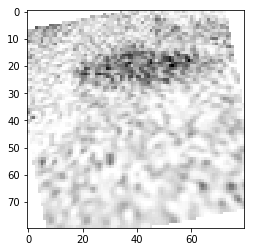

In [20]:
import matplotlib.pyplot as plt

x = 15

images, labels = next(g, None)
#print(images[x])
print(labels[x])
#len(images)

plt.imshow(images[x].reshape(80, 80), cmap="Greys");

In [6]:
p2 = Augmentor.Pipeline('8-bit_lowfat/training_data/', output_directory='../../output')
p2.status()


batch_size = 32
g2 = p2.keras_generator(batch_size=batch_size)

#train_datagen = ImageDataGenerator(preprocessing_function=p.keras_preprocess_func())
#training_data = train_datagen.flow_from_directory('8-bit_lowfat/training_data', target_size = (80, 80), batch_size = 32, class_mode = 'binary', color_mode = 'grayscale', save_format='tif')

print "Done!\n"

Initialised with 245 image(s) found.
Output directory set to 8-bit_lowfat/training_data/../../output.Operations: 0
Images: 245
Classes: 2
	Class index: 0 Class label: cell 
	Class index: 1 Class label: nocell 
Dimensions: 1
	Width: 80 Height: 80
Formats: 1
	 TIFF

You can remove operations using the appropriate index and the remove_operation(index) function.
Done!



[1 0]


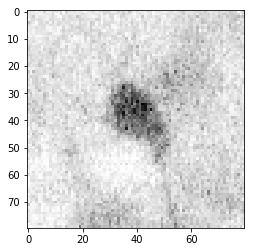

In [42]:
images2, labels2 = next(g2, None)
print(labels2[x])
#len(images)

plt.imshow(images2[x].reshape(80, 80), cmap="Greys");

In [8]:
#=============================================================================================
# Fitting model to data
#=============================================================================================

print "Fitting model to data..."

# Find number of epoch and validation steps
#steps_epoch = len([filename for filename in os.listdir('8-bit_lowfat/training_data/cell') if filename.endswith(".tif")]) + len([filename for filename in os.listdir('8-bit_lowfat/training_data/nocell') if filename.endswith(".tif")])
steps_valid = len([filename for filename in os.listdir('8-bit_lowfat/test_data/cell') if filename.endswith(".tif")]) + len([filename for filename in os.listdir('8-bit_lowfat/test_data/nocell') if filename.endswith(".tif")])

steps_epoch=len(p.augmentor_images)/batch_size

# Checkpoint to only save the best model, metric = val_acc
filepath = "cc_model_"+datetime.datetime.today().strftime('%Y_%m_%d')+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='acc', patience=1,)
callbacks_list = [checkpoint, earlystop]


# steps_per_epoch is number of images in training set
history = classifier.fit_generator(g, steps_per_epoch = steps_epoch, epochs = 30, callbacks=callbacks_list, validation_data = test_data, validation_steps = steps_valid, shuffle = True, verbose=1)

print "Done!\n"

Fitting model to data...
Epoch 1/30
6/7 [========================>.....] - ETA: 0s - loss: 1.4902 - acc: 0.5208

KeyboardInterrupt: 

In [ ]:
#=============================================================================================
# Plotting accuracy
#=============================================================================================

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.legend()
plt.savefig('Acc_starting.png')
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()
plt.savefig('Loss_starting.png')
plt.show()

In [ ]:
# Finally evaluating model on the test data

test_generator = test_datagen.flow_from_directory(
'8-bit/training_data',
target_size=(80, 80),
batch_size=32,
class_mode='binary',
color_mode = 'grayscale',
shuffle=False)
test_loss, test_acc = classifier.evaluate_generator(test_generator, steps=200)
print('test acc:', test_acc)

In [ ]:
# Generating confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
#predictions = classifier.predict_generator(test_generator)
#matrix = metrics.confusion_matrix(test_generator, predictions)
#print(matrix)

#Confution Matrix and Classification Report
Y_pred = classifier.predict_generator(test_generator)
Y_pred[Y_pred > 0.5] = 1
Y_pred[Y_pred < 0.5] = 0
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, Y_pred))
print('Classification Report')
target_names = ['Cell','Nocell']
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))

In [ ]:
from keras import backend as K
K.image_data_format()